## Obtención de los datos

In [42]:
import pandas as pd

# Leer los datos
df = pd.read_csv('datos_2023.csv', delimiter=';')

# Concatenar los DataFrames de las tres primeras columnas y las columnas de 2023
# df = df.iloc[:, 3:]

## EDA

In [ ]:
# Convertir las columnas relevantes a tipo numérico
columnas_numericas = ['unidades_productivas_primario_2023', 'unidades_productivas_secundario_2023', 'unidades_productivas_terciario_2023',
                      'ocupados_primario_2023', 'ocupados_secundario_2023', 'ocupados_terciario_2023']
df[columnas_numericas] = df[columnas_numericas].apply(pd.to_numeric, errors='coerce')

# Calcular estadísticas descriptivas
stats_unidades_productivas = df[['unidades_productivas_primario_2023', 'unidades_productivas_secundario_2023', 'unidades_productivas_terciario_2023']].describe()
stats_ocupados = df[['ocupados_primario_2023', 'ocupados_secundario_2023', 'ocupados_terciario_2023']].describe()

# Visualizar las estadísticas descriptivas
print("Estadísticas de unidades productivas por sector:")
print(stats_unidades_productivas)

print("\nEstadísticas de ocupados por sector:")
print(stats_ocupados)

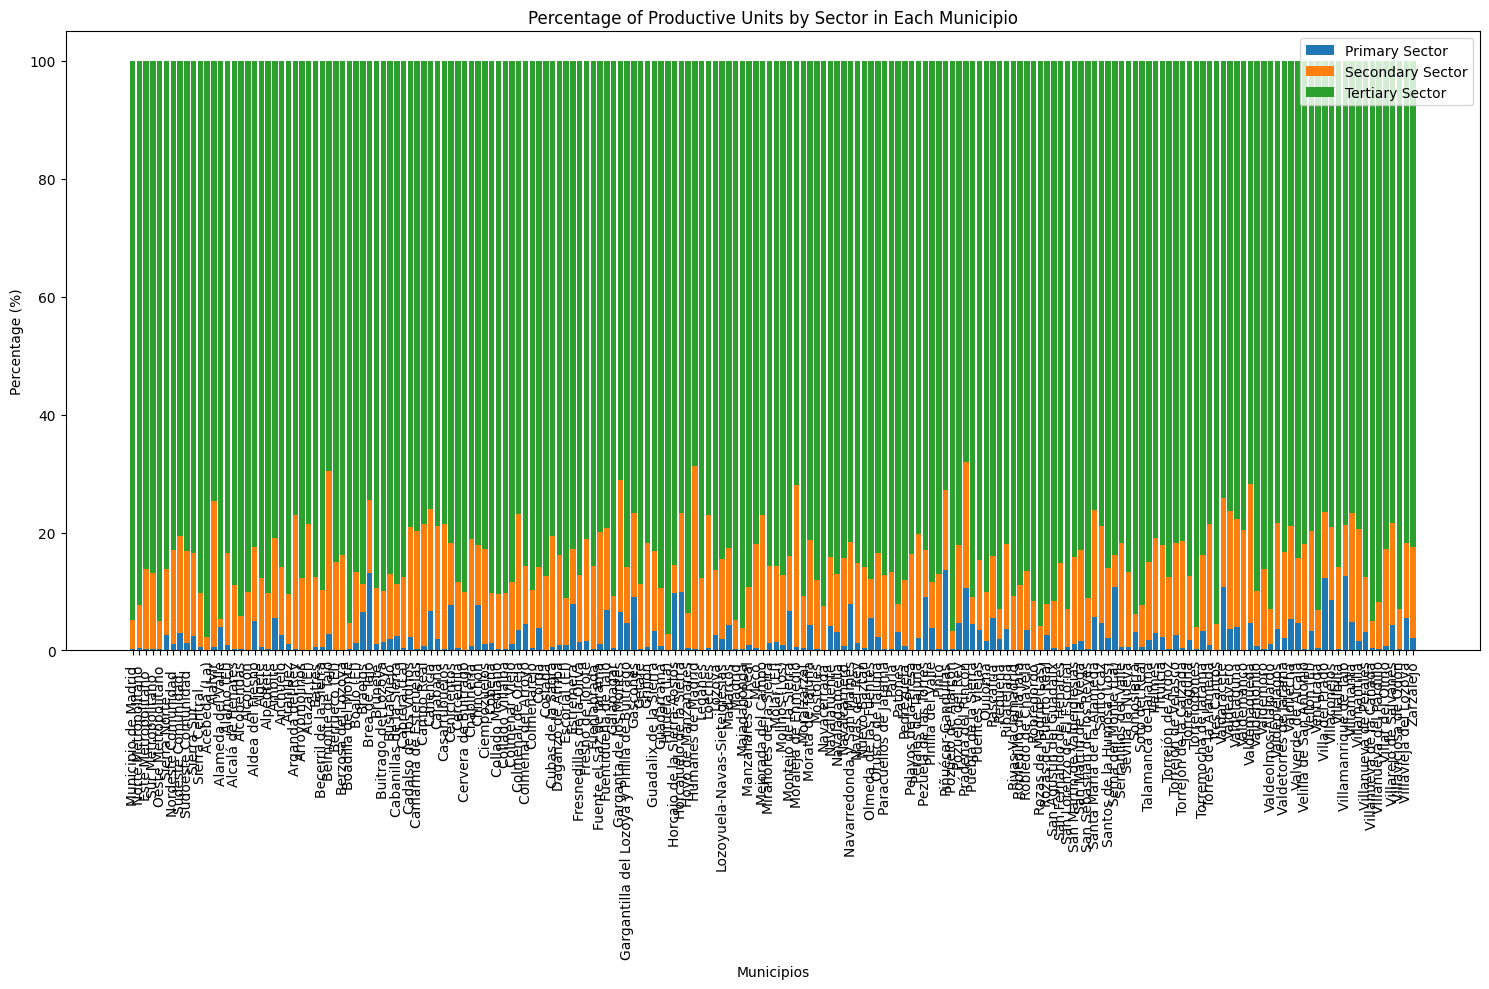

In [43]:
# Let's first re-read the data from the CSV to ensure we have the correct data frame
from matplotlib import pyplot as plt


data = df

# Since we know the structure of the data now, let's directly calculate the percentages for the productive units in each sector
data['total_units'] = data[['unidades_productivas_primario_2023', 'unidades_productivas_secundario_2023', 'unidades_productivas_terciario_2023']].sum(axis=1)

# Now we calculate the percentages
data['percent_primary'] = (data['unidades_productivas_primario_2023'] / data['total_units']) * 100
data['percent_secondary'] = (data['unidades_productivas_secundario_2023'] / data['total_units']) * 100
data['percent_tertiary'] = (data['unidades_productivas_terciario_2023'] / data['total_units']) * 100

# We will exclude the first row because it is the sum for the whole community and not a single municipio
municipios_data = data.iloc[1:]

# Set up the plot
plt.figure(figsize=(15, 10))

# Plot each sector's percentage for each municipio
plt.bar(municipios_data.index, municipios_data['percent_primary'], label='Primary Sector')
plt.bar(municipios_data.index, municipios_data['percent_secondary'], bottom=municipios_data['percent_primary'], label='Secondary Sector')
plt.bar(municipios_data.index, municipios_data['percent_tertiary'], bottom=municipios_data['percent_primary'] + municipios_data['percent_secondary'], label='Tertiary Sector')

# Add labels and title
plt.xlabel('Municipios')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Productive Units by Sector in Each Municipio')
plt.xticks(municipios_data.index, municipios_data['Nombre'], rotation='vertical')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


In [46]:
# Select columns related to the primary and secondary sectors' area and productive units
sector_area_data = data[
    ['Nombre',
     'unidades_productivas_primario_2023', 'ocupados_primario_2023', 'sup_explotaciones_agricolas_total',
     'unidades_productivas_secundario_2023', 'ocupados_secundario_2023', 'sup_total_indust']
]

# Convert agricultural and industrial areas from string to numeric (if necessary), assuming they are in hectares
# and remove any possible non-numeric characters that might be present
for col in ['sup_explotaciones_agricolas_total', 'sup_total_indust']:
    sector_area_data[col] = pd.to_numeric(sector_area_data[col].astype(str).str.replace('[^\d.]', ''), errors='coerce')

# Drop rows with missing area values to avoid skewing the analysis
sector_area_data = sector_area_data.dropna(subset=['sup_explotaciones_agricolas_total', 'sup_total_indust'])

# Calculate ratios of productive units and employed individuals to area for primary and secondary sectors
sector_area_data['ratio_unidades_prod_primario'] = sector_area_data['unidades_productivas_primario_2023'] / sector_area_data['sup_explotaciones_agricolas_total']
sector_area_data['ratio_ocupados_primario'] = sector_area_data['ocupados_primario_2023'] / sector_area_data['sup_explotaciones_agricolas_total']
sector_area_data['ratio_unidades_prod_secundario'] = sector_area_data['unidades_productivas_secundario_2023'] / sector_area_data['sup_total_indust']
sector_area_data['ratio_ocupados_secundario'] = sector_area_data['ocupados_secundario_2023'] / sector_area_data['sup_total_indust']

# Display the new ratios in the context of the names of the municipalities
sector_area_data[['Nombre', 'ratio_unidades_prod_primario', 'ratio_ocupados_primario', 'ratio_unidades_prod_secundario', 'ratio_ocupados_secundario']].head()


C:\Users\ana\AppData\Local\Temp\ipykernel_16304\1881780151.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_area_data[col] = pd.to_numeric(sector_area_data[col].astype(str).str.replace('[^\d.]', ''), errors='coerce')
C:\Users\ana\AppData\Local\Temp\ipykernel_16304\1881780151.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_area_data[col] = pd.to_numeric(sector_area_data[col].astype(str).str.replace('[^\d.]', ''), errors='coerce')


,Nombre,ratio_unidades_prod_primario,ratio_ocupados_primario,ratio_unidades_prod_secundario,ratio_ocupados_secundario
0,Comunidad de Madrid,0.015643,0.030198,9.826374,50.805899
1,Municipio de Madrid,0.758091,1.564948,3.628782,18.370999
2,Norte Metropolitano,inf,inf,inf,inf
3,Este Metropolitano,inf,inf,inf,inf
4,Sur Metropolitano,0.016872,0.052953,inf,inf


In [48]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare the data by selecting relevant columns and filling missing values
data['total_units_primary'] = data['unidades_productivas_primario_2023']
data['total_occupied_primary'] = data['ocupados_primario_2023']
data['total_area_primary'] = data['sup_explotaciones_agricolas_total'].replace('[^\d.]', '', regex=True).astype(float)

data['total_units_secondary'] = data['unidades_productivas_secundario_2023']
data['total_occupied_secondary'] = data['ocupados_secundario_2023']
data['total_area_secondary'] = data['sup_total_indust'].replace('[^\d.]', '', regex=True).astype(float)

data['total_units_tertiary'] = data['unidades_productivas_terciario_2023']
data['total_occupied_tertiary'] = data['ocupados_terciario_2023']

# Fill NA values with 0 (assumes no data means no units or area)
clustering_features = data[[
    'total_units_primary', 'total_occupied_primary', 'total_area_primary',
    'total_units_secondary', 'total_occupied_secondary', 'total_area_secondary',
    'total_units_tertiary', 'total_occupied_tertiary'
]].fillna(0)

# Normalize the data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(clustering_features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)  # 3 clusters for primary, secondary, tertiary
cluster_labels = kmeans.fit_predict(normalized_features)

# Assign cluster labels to the original data
data['cluster'] = cluster_labels

# Determine the predominant sector in each cluster
cluster_centers = kmeans.cluster_centers_
sector_labels = ['Primary', 'Secondary', 'Tertiary']

# Mapping clusters to sectors based on the dominant features at cluster centers
dominant_sectors = {i: sector_labels[np.argmax(cluster_centers[i, :3])] for i in range(3)}
data['predominant_sector'] = data['cluster'].map(dominant_sectors)

# Save or display the results
data[['Nombre', 'cluster', 'predominant_sector']].to_csv('clustered_data.csv', index=False)  # Save to CSV
print(data[['Nombre', 'cluster', 'predominant_sector']].head())  # Print the first few rows


                 Nombre  cluster predominant_sector
0   Comunidad de Madrid        1           Tertiary
1  Municipio de Madrid         2          Secondary
2  Norte Metropolitano         0           Tertiary
3  Este Metropolitano          0           Tertiary
4  Sur Metropolitano           0           Tertiary


c:\Users\ana\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
